In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr        #to help us read data from any website
import datetime as dt
import yfinance as yf

In [2]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2022,12,31)

In [3]:
yf.pdr_override()

In [4]:
df = pdr.get_data_yahoo('AAPL',start,end)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565691,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873644,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875883,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210678,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140915,237458000


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.658981,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.831772,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.847855,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.412415,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.731918,77034200


In [7]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565691,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873644,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875883,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210678,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140915,237458000


In [8]:
df = df.drop(['Date','Adj Close'],axis=1)
df.head()

,Open,High,Low,Close,Volume
0,27.847500,27.860001,26.837500,27.332500,212818400
1,27.072500,27.162500,26.352501,26.562500,257142000
2,26.635000,26.857500,26.157499,26.565001,263188400
3,26.799999,27.049999,26.674999,26.937500,160423600
4,27.307501,28.037500,27.174999,27.972500,237458000


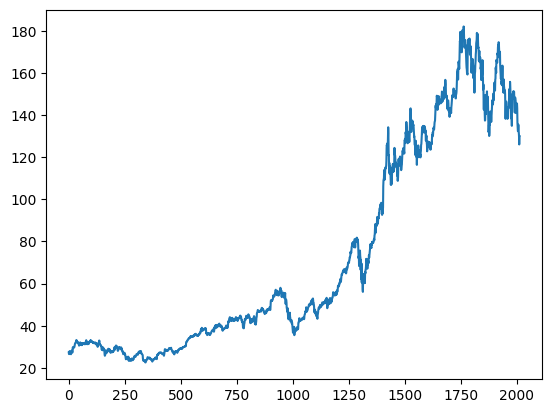

In [9]:
plt.plot(df.Close)

In [10]:
# plotting the moving average 
# 100 days moving average
ma100 = df.Close.rolling(100).mean()
ma100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
2009    150.515600
2010    150.157800
2011    149.764699
2012    149.412100
2013    149.062199
Name: Close, Length: 2014, dtype: float64

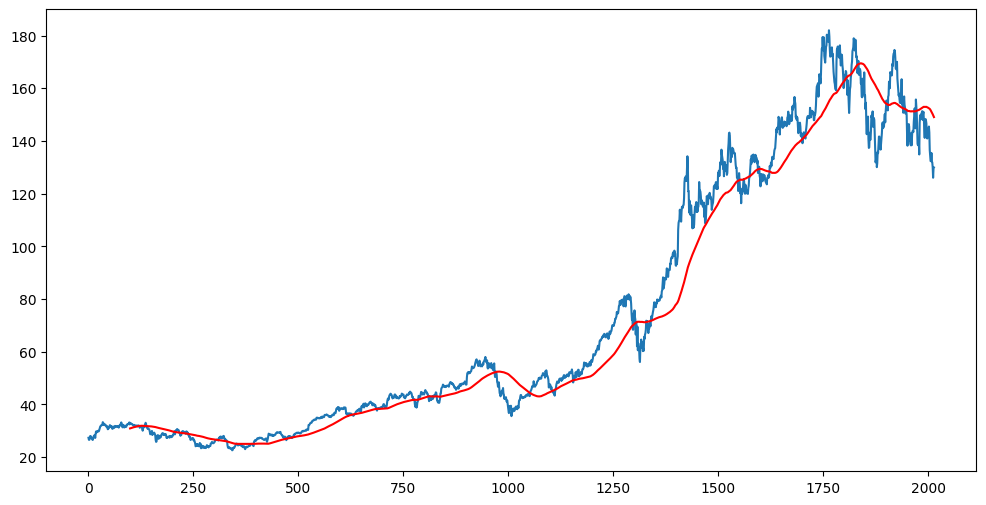

In [11]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')

In [12]:
#200 days moving average
ma200 = df.Close.rolling(200).mean()
ma200

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2009    152.1331
2010    152.0096
2011    151.8867
2012    151.7593
2013    151.6110
Name: Close, Length: 2014, dtype: float64

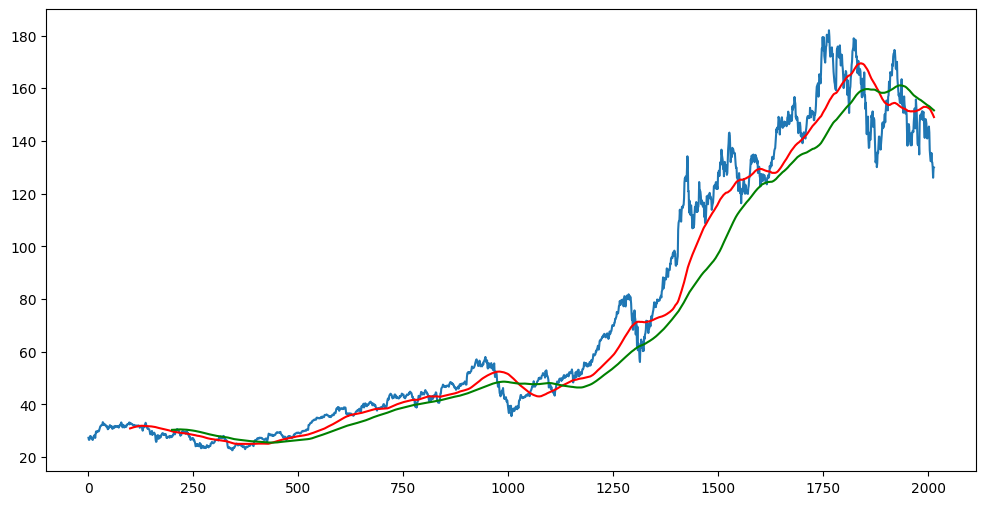

In [13]:
#plotting 100 days moving average and 200 days moving average
#mostly technical analysts follow the strategy that if the 200 days moving average is above 100 days moving avg then it is an up trend an vice versa
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [14]:
df.shape

(2014, 5)

In [15]:
#splitting data into traning and testing
data_train = pd.DataFrame(df["Close"][0:int(len(df)*0.7)])
data_test = pd.DataFrame(df["Close"][int(len(df)*0.7):int(len(df))])

print(data_train.shape)
print(data_test.shape)

(1409, 1)
(605, 1)


In [16]:
data_train.head()

,Close
0,27.332500
1,26.562500
2,26.565001
3,26.937500
4,27.972500


In [17]:
data_test.head()

,Close
1409,111.112503
1410,112.727501
1411,109.375000
1412,113.010002
1413,115.010002


In [18]:
#for the stack lstm model we need to scale down the data between 0 and 1
#for that we need MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [19]:
data_train_array = scaler.fit_transform(data_train)
data_train_array

array([[0.05198896],
       [0.04355683],
       [0.04358422],
       ...,
       [0.95359602],
       [0.95794895],
       [1.        ]])

In [20]:
data_train_array.shape

(1409, 1)

The logic used here is:

Suppose we have the closing prices for 10 days and using tahat we predict the 11th day

The price on a particular day of a stock is dependent on the previous few days

                     X_train              y_train
                     
Example: 34 36 33 40 39 38 37 42 44 38 -     43

         36 33 40 39 38 37 42 44 38 43 -     42
         
In the same way we predict further and train our model
We can also change the steps from 10 to any number of your choice


In [22]:
#now we will divide our data into X (feature) and y (label) for training and testing
X_train = []
y_train = []

for i in range(100, data_train_array.shape[0]):
    X_train.append(data_train_array[i-100:i])
    y_train.append(data_train_array[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [23]:
X_train

array([[[0.05198896],
        [0.04355683],
        [0.04358422],
        ...,
        [0.11553097],
        [0.10753689],
        [0.11416212]],

       [[0.04355683],
        [0.04358422],
        [0.04766338],
        ...,
        [0.10753689],
        [0.11416212],
        [0.11345033]],

       [[0.04358422],
        [0.04766338],
        [0.05899746],
        ...,
        [0.11416212],
        [0.11345033],
        [0.10934378]],

       ...,

       [[0.4322556 ],
        [0.51367484],
        [0.41577467],
        ...,
        [0.80603395],
        [0.91630855],
        [0.9456293 ]],

       [[0.51367484],
        [0.41577467],
        [0.44493117],
        ...,
        [0.91630855],
        [0.9456293 ],
        [0.95359602]],

       [[0.41577467],
        [0.44493117],
        [0.4279848 ],
        ...,
        [0.9456293 ],
        [0.95359602],
        [0.95794895]]])

In [24]:
y_train

array([0.11345033, 0.10934378, 0.11005557, ..., 0.95359602, 0.95794895,
       1.        ])

**ML MODEL**

In [26]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [30]:
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, 
               input_shape = (X_train.shape[1],1))) #1 as we are working with only one colum for predicting the closing price
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu')) 
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_8 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_9 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_10 (Dropout)        (None, 100, 80)           0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

In [34]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
41/41 [==============================] - 27s 416ms/step - loss: 0.0211
Epoch 2/50
41/41 [==============================] - 17s 411ms/step - loss: 0.0058
Epoch 3/50
41/41 [==============================] - 17s 409ms/step - loss: 0.0044
Epoch 4/50
41/41 [==============================] - 17s 405ms/step - loss: 0.0037
Epoch 5/50
41/41 [==============================] - 16s 393ms/step - loss: 0.0036
Epoch 6/50
41/41 [==============================] - 16s 391ms/step - loss: 0.0035
Epoch 7/50
41/41 [==============================] - 16s 390ms/step - loss: 0.0028
Epoch 8/50
41/41 [==============================] - 16s 393ms/step - loss: 0.0032
Epoch 9/50
41/41 [==============================] - 16s 390ms/step - loss: 0.0032
Epoch 10/50
41/41 [==============================] - 16s 396ms/step - loss: 0.0031
Epoch 11/50
41/41 [==============================] - 16s 391ms/step - loss: 0.0026
Epoch 12/50
41/41 [==============================] - 16s 395ms/step - loss: 0.0036
Epoch 13/50
4

In [35]:
model.save('keras_model.h5')

In [36]:
data_test.head()

,Close
1409,111.112503
1410,112.727501
1411,109.375000
1412,113.010002
1413,115.010002


In [37]:
data_train.tail() 

,Close
1404,106.260002
1405,108.937500
1406,109.665001
1407,110.062500
1408,113.902496


In [38]:
past_100_days = data_train.tail(100) 
#we need the past 100 days from the training data to test is for the next in the testing data
#this is because our model predicts the closing price of the present day on the basis of previous 100 days

In [39]:
final_df = past_100_days.append(data_test, ignore_index = True)

C:\Users\shrey\AppData\Local\Temp\ipykernel_13960\1519072522.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(data_test, ignore_index = True)


In [40]:
final_df.head()

,Close
0,63.215000
1,61.667500
2,61.195000
3,57.310001
4,56.092499


In [41]:
#We need to apply scaling again as the data in the training set os not scaled
input_data = scaler.fit_transform(final_df)
input_data

array([[0.05656483],
       [0.04427503],
       [0.04052257],
       [0.00966905],
       [0.        ],
       [0.04469198],
       [0.0419918 ],
       [0.06764351],
       [0.04639945],
       [0.0604364 ],
       [0.05940397],
       [0.03283898],
       [0.04082037],
       [0.03383169],
       [0.07564478],
       [0.06960907],
       [0.08279233],
       [0.08660432],
       [0.09704768],
       [0.12444655],
       [0.11924474],
       [0.12373183],
       [0.11600849],
       [0.10435404],
       [0.08735879],
       [0.10270616],
       [0.10058174],
       [0.11634604],
       [0.11674315],
       [0.10762998],
       [0.12579669],
       [0.13784818],
       [0.12845715],
       [0.13657754],
       [0.14531341],
       [0.15140868],
       [0.15758333],
       [0.17027024],
       [0.17995914],
       [0.17281159],
       [0.16534636],
       [0.16909885],
       [0.16546548],
       [0.17985983],
       [0.1762464 ],
       [0.18833764],
       [0.18361231],
       [0.187

In [42]:
input_data.shape

(705, 1)

In [43]:
X_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    X_test.append(input_data[i-100: i])
    y_test.append(input_data[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [44]:
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_test.shape:  (605, 100, 1)
y_test.shape:  (605,)


**Making predictions**

In [45]:
y_predicted = model.predict(X_test)

19/19 [==============================] - 4s 123ms/step


In [46]:
y_predicted.shape

(605, 1)

In [47]:
y_predicted

array([[0.3418035 ],
       [0.35531008],
       [0.3710661 ],
       [0.38768303],
       [0.40420526],
       [0.42010945],
       [0.4350133 ],
       [0.44856536],
       [0.46058142],
       [0.4709564 ],
       [0.47992402],
       [0.48832685],
       [0.49698097],
       [0.5062459 ],
       [0.51625985],
       [0.5266786 ],
       [0.5369359 ],
       [0.54694736],
       [0.55718017],
       [0.56762576],
       [0.57671833],
       [0.58308655],
       [0.5850537 ],
       [0.58229476],
       [0.57485753],
       [0.56320405],
       [0.5485305 ],
       [0.5322275 ],
       [0.51530534],
       [0.49845308],
       [0.4819206 ],
       [0.46624553],
       [0.4521736 ],
       [0.4398995 ],
       [0.42955816],
       [0.4216156 ],
       [0.41666973],
       [0.41498268],
       [0.4166239 ],
       [0.42142683],
       [0.42853957],
       [0.4373026 ],
       [0.44669735],
       [0.45599622],
       [0.46464813],
       [0.47249508],
       [0.4802282 ],
       [0.488

In [48]:
y_test

array([0.43695282, 0.44977866, 0.42315407, 0.4520222 , 0.46790562,
       0.46709158, 0.46470905, 0.47229339, 0.47344491, 0.49383529,
       0.54224001, 0.55405326, 0.54585344, 0.55933451, 0.5473227 ,
       0.54571451, 0.57932771, 0.62014809, 0.59807015, 0.5145234 ,
       0.51515875, 0.45051326, 0.48625094, 0.45583419, 0.44400106,
       0.4706852 , 0.47211471, 0.44503346, 0.43081779, 0.40302181,
       0.42875299, 0.44249211, 0.40524554, 0.41398141, 0.44622473,
       0.46750851, 0.4605992 , 0.47425895, 0.48204185, 0.45210157,
       0.47973874, 0.45321347, 0.46846153, 0.46758794, 0.48347136,
       0.54247825, 0.51627059, 0.51698537, 0.51317333, 0.49975182,
       0.47560908, 0.48775989, 0.4826772 , 0.47378246, 0.46814386,
       0.46822329, 0.4805329 , 0.43764767, 0.47036753, 0.4190641 ,
       0.41834931, 0.43161201, 0.46742907, 0.49983126, 0.4971311 ,
       0.47830923, 0.47552965, 0.50348443, 0.50126077, 0.50165788,
       0.50991726, 0.50269028, 0.49188955, 0.49673399, 0.48640

In [49]:
scaler.scale_  #factor by which the prices or input values were scaled down

array([0.00794171])

In [52]:
scale_factor = 1/scaler.scale_
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

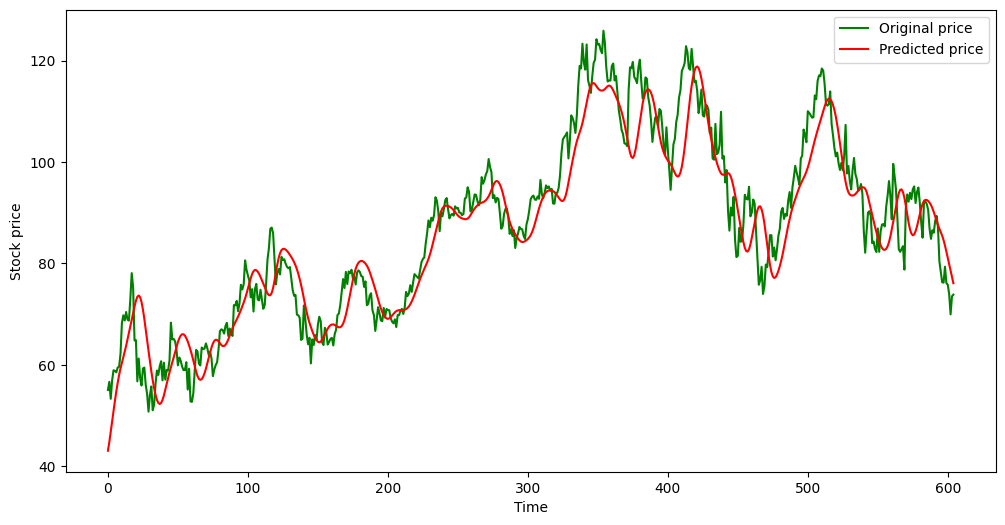

In [56]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'g', label = 'Original price')
plt.plot(y_predicted, 'r', label = 'Predicted price')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()   #shows the labels for green and red lines
plt.show()